In [12]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [13]:
# Datensatz geladen
ims_cube = scipy.io.loadmat("ims_cube.mat")['ims_cube']


Beispielkanäle plotten um einzelne Spektren zu veranschaulichen


Datenform: (128, 128, 191)
Datentyp: float64


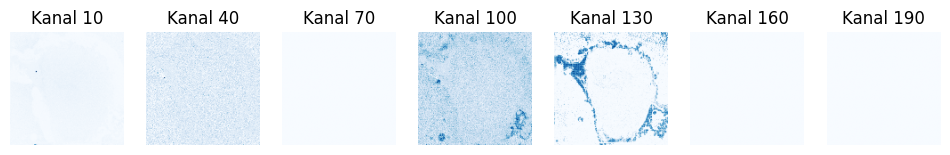

<Figure size 640x480 with 0 Axes>

In [14]:
# 1. Datensatz laden
data = scipy.io.loadmat("ims_cube.mat")
ims_cube = data['ims_cube'] # Datenwürfel mit x,y Position und m/z als Kanalindex
                            # z = eine Liste an Werten

# eintlich ist es kein Würfel
# Man hat ein 2d Bild mit x und y Werten und zu jedem x und y eine Liste [m/z]

# Man hat ein Objekt, schießt mit 190 verschiedenen Lasereinstellungen drauf
# und speichert dann nach jedem Beschuss pro Pixel den "Rückgabewert"
# dadurch hat man dann 190 mal das gleiche Bild nur mit unterschiedlichen Werten,
# da z.B. einmal Proteine(Kanal 34) und einmal Gelatine(Kanal 47) fokussiert sind
# Also nur der Fokus ist unterschiedlich


# Grundlegende Infos über Struktur des Würfels
print("Datenform:", ims_cube.shape)  # (x, y, kanäle)
print("Datentyp:", ims_cube.dtype)

# 2. Beispielhafte Visualisierung einzelner Kanäle
num_channels = ims_cube.shape[2]

# Die Kanäle für output angeben
channels_to_plot = [10, 40, 70, 100, 130, 160, 190]


# Neue Abbildung mit definierter Größe
plt.figure(figsize=(12, 6))

# Schleife über alle ausgewählten Kanäle
for i, ch in enumerate(channels_to_plot, 1):
    # Lege Position für das aktuelle Teilbild fest (1 Zeile, mehrere Spalten)
    plt.subplot(1, len(channels_to_plot), i)

    # Zeige den jeweiligen Kanal als 2D-Bild
    plt.imshow(ims_cube[:, :, ch], cmap='Blues')
    plt.title(f"Kanal {ch}")  # Beschrifte das Teilbild
    plt.axis('off')           # Achsen ausblenden für saubere Darstellung

# Zeige alle Teilbilder nebeneinander an
plt.show()

plt.suptitle("Räumliche Verteilung ausgewählter Kanäle")
plt.show()


Alle Kanäle eines Pixels plotten, damit sieht man welche Frequenzen in diesem Pixel am relevantesten sind

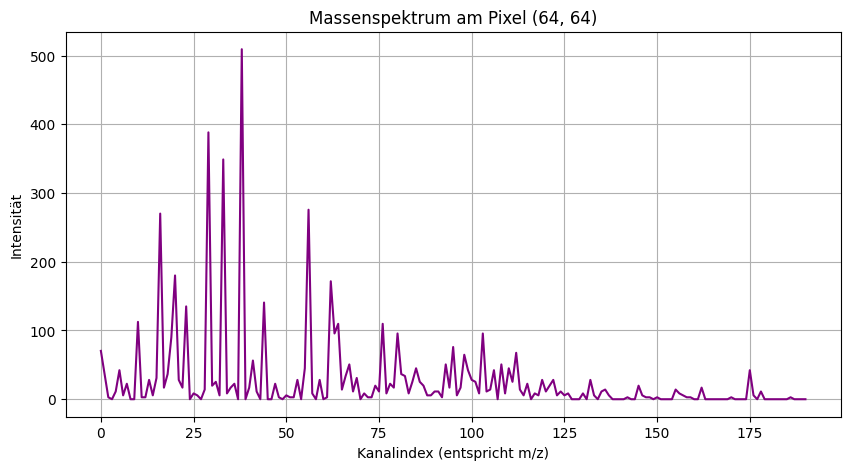

In [15]:
# Beispiel: Pixel in der Mitte des Bildes
row_index, col_index = ims_cube.shape[0] // 2, ims_cube.shape[1] // 2
spectrum = ims_cube[row_index, col_index, :]

plt.figure(figsize=(10, 5))
plt.plot(spectrum, color='purple')
plt.title(f"Massenspektrum am Pixel ({row_index}, {col_index})")
plt.xlabel("Kanalindex (entspricht m/z)")
plt.ylabel("Intensität")
plt.grid(True)
plt.show()


Principal-Component-Analysis(PCA) Motivation

Wir haben oben die Intensität der Kanäle für ein Pixel gesehen.
In unserem Beispiel haben wir lediglich 191 verschiedene Kanäle pro Pixel, allerdings könnten das auch 10.000 sein.
Da viele Kanäle einfach ein Rauschen sein werden kann man mittels einer PCA Analyse Die Dimensionen von 191-D auf z.B. 10-D reduzieren.

Das reduziert den Speicher- und Rechenaufwand, außerdem treten die wichtigsten Kanäle stärker hervor



In [23]:
# Umformung für PCA:    jeder Pixel = eine Zeile,
#                       jeder Kanal = eine Spalte

# X = Input-Matrix (128, 128, 191)
X = ims_cube.reshape(-1, ims_cube.shape[2]) # reduziert Matrix von 3D -> 2D
                                            # -1 fasst die ersten beiden Dimensionen 128x128 zu 16384 Zeilen zusammen
print("Neue Form:", X.shape) # = (16384, 191)


# Normalisierung der Intensitäten pro Pixel (verhindert Ausreißer bei Helligkeit z.B.)
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)

# PCA anwenden, um Hauptkomponenten zu extrahieren
n_components =  191 # Anzahl gewünschter Hauptkomponenten macht hier keinen Sinn weil man nicht reduziert aber gut für                      # visualisierung der Varianz
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)


Neue Form: (16384, 191)


Varianz

Wie viele Dimensionen nach PCA decken wie viel Prozent aller Daten ab?


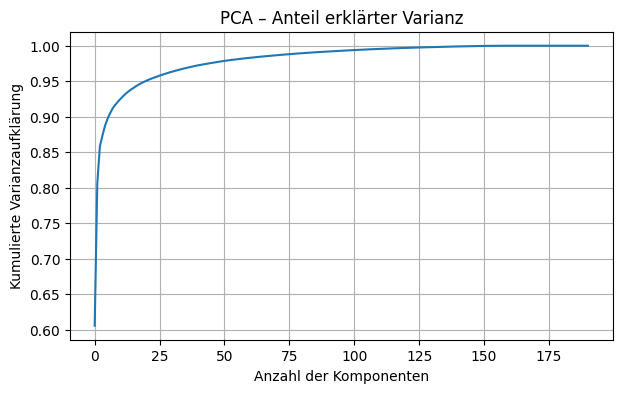

In [24]:
# UMGANGSSPRACHE, NOCH ÄNDERN! "Wie viele Kanäle spiegeln wie viel Prozent der Informationen wieder"
plt.figure(figsize=(7, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Anzahl der Komponenten')
plt.ylabel('Kumulierte Varianzaufklärung')
plt.title('PCA – Anteil erklärter Varianz')
plt.grid(True)
plt.show()


Wichtigste m/z-Kanäle: [132  38  29  33  16  56 135  64 103  44]


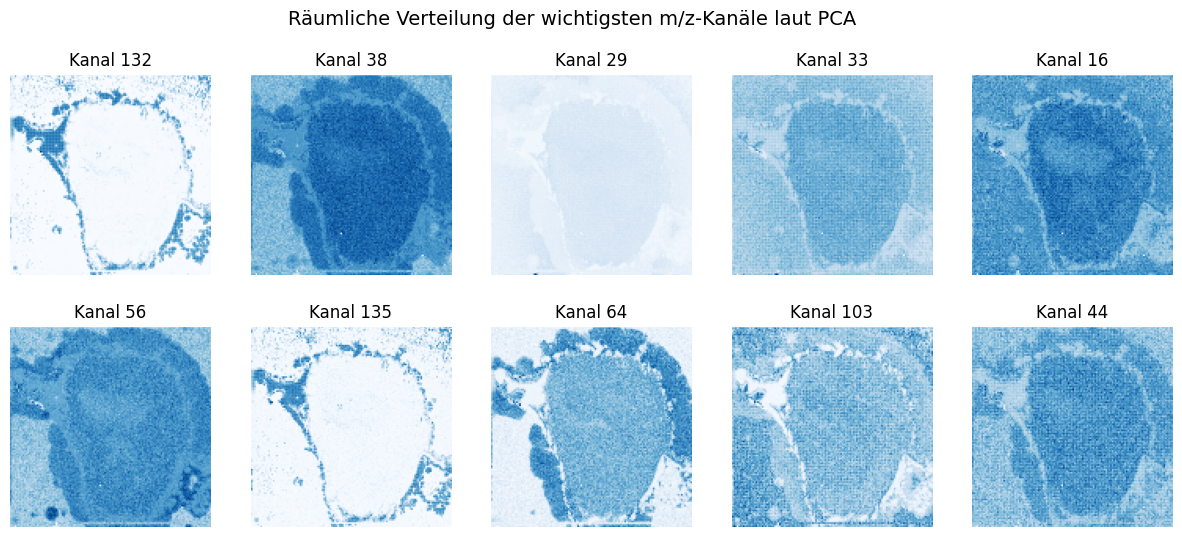

In [18]:
# Wichtigste Kanäle (m/z-Werte) herausfinden
# Wir betrachten hier die erste Hauptkomponente
loadings = np.abs(pca.components_[0])
important_channels = np.argsort(loadings)[-10:][::-1]  # Top 10 mit höchstem Einfluss

print("Wichtigste m/z-Kanäle:", important_channels)

# Diese Kanäle im Bild visualisieren
plt.figure(figsize=(15, 6))
for i, ch in enumerate(important_channels, 1):
    plt.subplot(2, 5, i)
    plt.imshow(ims_cube[:, :, ch], cmap='Blues')
    plt.title(f"Kanal {ch}")
    plt.axis('off')

plt.suptitle("Räumliche Verteilung der wichtigsten m/z-Kanäle laut PCA", fontsize=14)
plt.show()



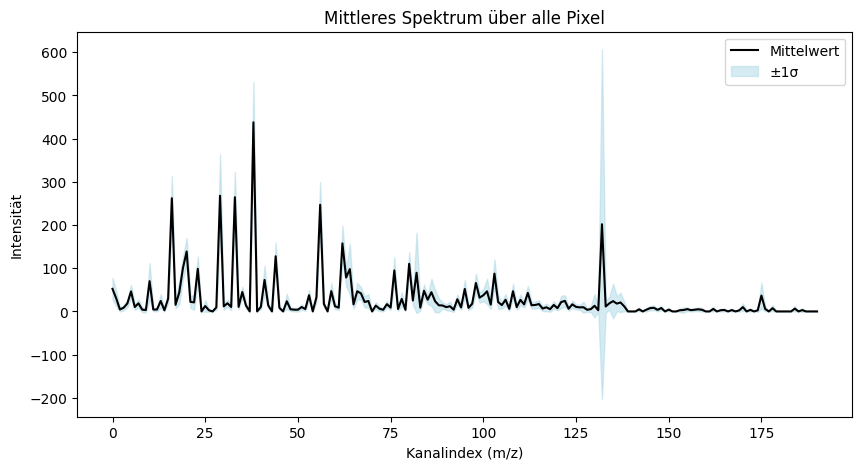

In [19]:
# (Optional) Mittleres Spektrum über alle Pixel + Standardabweichung
mean_spectrum = ims_cube.mean(axis=(0, 1))
std_spectrum = ims_cube.std(axis=(0, 1))

plt.figure(figsize=(10, 5))
plt.plot(mean_spectrum, label='Mittelwert', color='black')
plt.fill_between(range(len(mean_spectrum)),
                 mean_spectrum - std_spectrum,
                 mean_spectrum + std_spectrum,
                 color='lightblue', alpha=0.5, label='±1σ')
plt.title("Mittleres Spektrum über alle Pixel")
plt.xlabel("Kanalindex (m/z)")
plt.ylabel("Intensität")
plt.legend()
plt.show()


Threshold Methode ist dafür da automatisch die optimale Anzahl an Kanälen zu wählen

(quasi den Knick bei der Varianzkurve)



In [20]:
print(1)

1
